In [1]:
# required packages
try:
    import os
    import nltk
    import warnings
    import random
    import numpy as np
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt
    from tqdm import tqdm
    from textblob import TextBlob
    from collections import Counter, defaultdict
    from nltk.sentiment import SentimentIntensityAnalyzer
    from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

    from surprise import SVDpp, Reader, Dataset
    from surprise.model_selection import GridSearchCV
    from gensim.models import Word2Vec

    from sklearn.linear_model import LinearRegression
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.model_selection import train_test_split
except:
    !pip install -r requirements.txt
sns.set(style = "whitegrid")
warnings.filterwarnings('ignore')
if not os.path.exists("vizs"):
        os.makedirs("vizs")

In [2]:
# load data
raw_recipes = pd.read_csv('data/RAW_recipes.csv')
raw_interaction = pd.read_csv('data/RAW_interactions.csv')

In [3]:
# break up nutrition into different measurements
raw_recipes[
    ['calories', 'total fat', 'sugar', 'sodium', 'protein', 'saturated fat', 'carbohydrates']
] = raw_recipes['nutrition'].str.split(",",expand=True) 
raw_recipes['calories'] = raw_recipes['calories'].apply(lambda x: x.replace("[", ""))
raw_recipes['carbohydrates'] = raw_recipes['carbohydrates'].apply(lambda x: x.replace("]", ""))
raw_recipes[
    ['calories', 'total fat', 'sugar', 'sodium', 'protein', 'saturated fat', 'carbohydrates']
] =  raw_recipes[
    ['calories', 'total fat', 'sugar', 'sodium', 'protein', 'saturated fat', 'carbohydrates']
].astype(float)

In [4]:
def iqr_bounds(col):
    q1 = np.percentile(raw_recipes[col],25)
    q3 = np.percentile(raw_recipes[col],75)
    iqr = q3 - q1
    return q1 - 1.5*iqr, q1 + 1.5*iqr

def drop_query(col, threshold, geq=True):
    """
    Helper to find indcies of observations that contains "unreasonable" values
    ---
    col: column to check
    threshold: threshold
    grq: if the cond will be >= (True), or <= (False)
    ---
    return indcies of observations have value >= or <= the threshold
    """
    if geq:
        return raw_recipes[raw_recipes[col] >= threshold].index.tolist()
    return raw_recipes[raw_recipes[col] <= threshold].index.tolist()

to_drop_idx = []
for col in ['calories', 'total fat', 'sugar', 'sodium', 'protein', 
            'saturated fat', 'carbohydrates', 'minutes', 'n_steps', 'n_ingredients']:
    lower, upper = iqr_bounds(col)
    to_drop_idx+=drop_query(col, lower, False) + drop_query(col, upper, True)
to_drop_idx = list(set(to_drop_idx))

# drop observations
cleaned_recipes = raw_recipes.drop(labels=to_drop_idx, axis=0)
print(f'Dropped {raw_recipes.shape[0] - cleaned_recipes.shape[0]} observations')

Dropped 136910 observations


In [5]:
# determine if a recipe is for dessert
all_tags = defaultdict(int)
for obs in cleaned_recipes['tags']:
    for tag in obs[1:-1].replace("'", '').split(", "):
        all_tags[tag] += 1
cleaned_recipes['is_dessert'] = cleaned_recipes['tags'].apply(lambda x: 'desserts' in x)
cleaned_recipes['10_and_more_steps'] = cleaned_recipes['n_steps'].apply(lambda x: x >= 10)
cleaned_recipes['description_len'] = cleaned_recipes['description'].str.len().fillna(0)

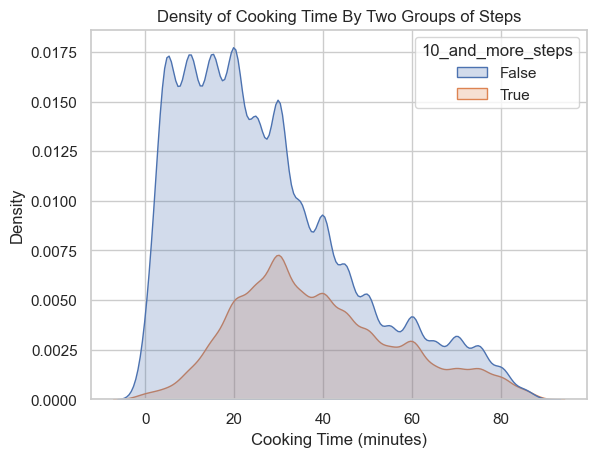

In [6]:
sns.kdeplot(data=cleaned_recipes, x='minutes', fill=True, hue='10_and_more_steps')
plt.title("Density of Cooking Time By Two Groups of Steps")
plt.xlabel("Cooking Time (minutes)")
plt.ylabel("Density")
plt.savefig("vizs/viz1.png")
plt.show()

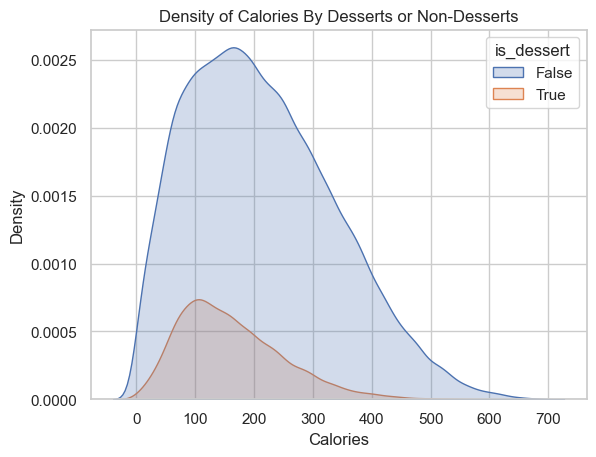

In [7]:
sns.kdeplot(data=cleaned_recipes, x='calories', fill=True, hue='is_dessert')
plt.title("Density of Calories By Desserts or Non-Desserts")
plt.xlabel("Calories")
plt.ylabel("Density")
plt.savefig("vizs/viz2.png")
plt.show()

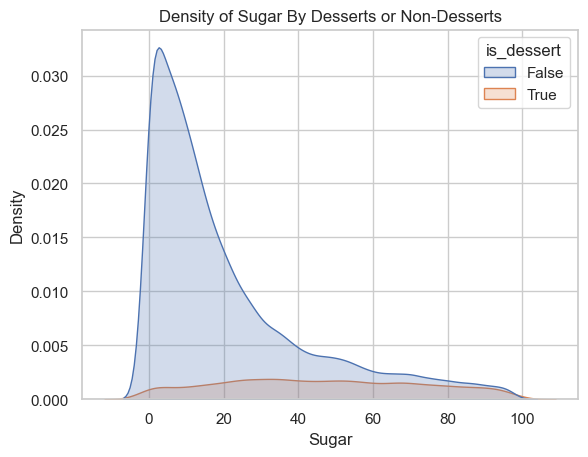

In [8]:
sns.kdeplot(data=cleaned_recipes, x='sugar', fill=True, hue='is_dessert')
plt.title("Density of Sugar By Desserts or Non-Desserts")
plt.xlabel("Sugar")
plt.ylabel("Density")
plt.savefig("vizs/viz3.png")
plt.show()

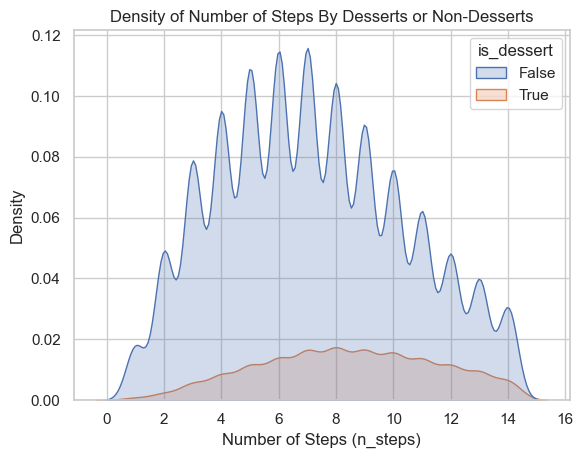

In [9]:
sns.kdeplot(data=cleaned_recipes, x='n_steps', fill=True, hue='is_dessert')
plt.title("Density of Number of Steps By Desserts or Non-Desserts")
plt.xlabel("Number of Steps (n_steps)")
plt.ylabel("Density")
plt.savefig("vizs/viz4.png")
plt.show()

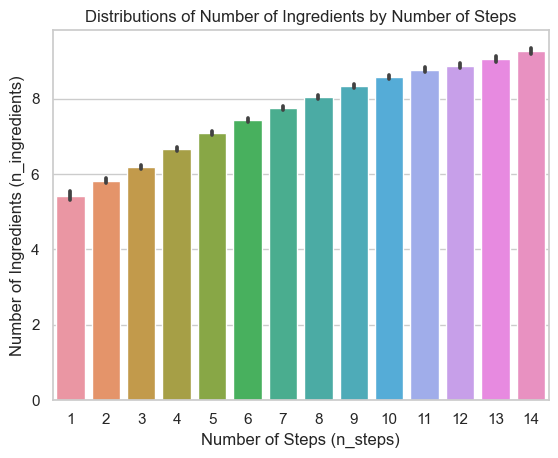

In [10]:
sns.barplot(data=cleaned_recipes, x="n_steps", y="n_ingredients")
plt.title("Distributions of Number of Ingredients by Number of Steps")
plt.xlabel("Number of Steps (n_steps)")
plt.ylabel("Number of Ingredients (n_ingredients)")
plt.savefig("vizs/viz5.png")
plt.show()

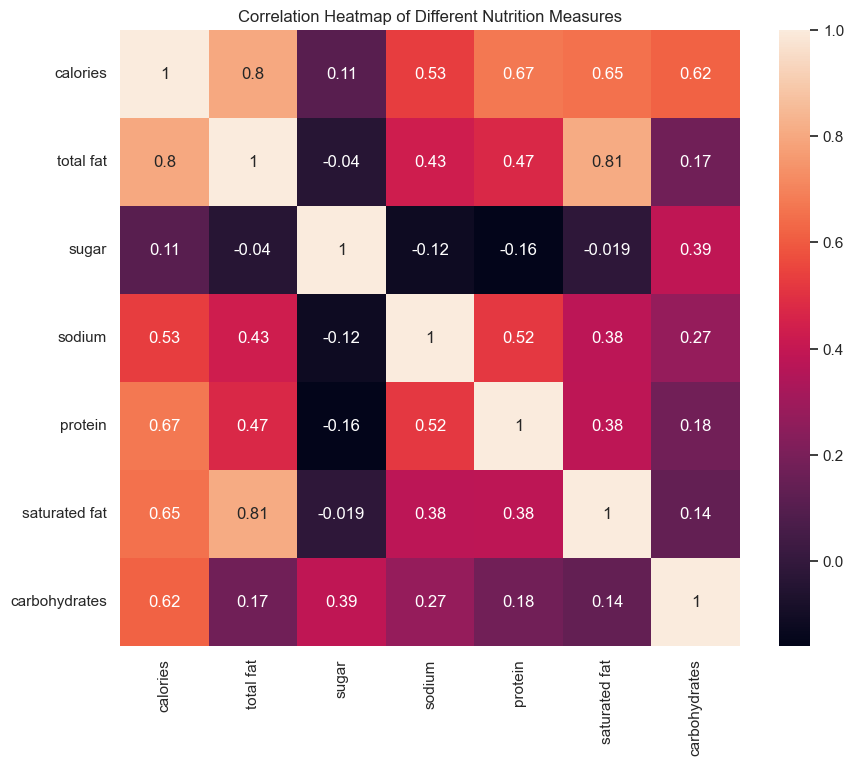

In [11]:
plt.figure(figsize=(10,8))
sns.heatmap(cleaned_recipes[
    ['calories', 'total fat', 'sugar', 'sodium', 'protein', 'saturated fat', 'carbohydrates']
].corr(), annot=True)
plt.title("Correlation Heatmap of Different Nutrition Measures")
plt.savefig("vizs/viz6.png")
plt.show()

In [12]:
# merge two dfs together
data = cleaned_recipes.merge(raw_interaction, left_on='id', right_on='recipe_id')
data = data.drop(columns='nutrition')
data = data.assign(steps=data['steps'].apply(lambda txt:txt[1:-1].replace("'", "")))
user_mean = np.round(data.groupby('user_id').mean()['rating']).to_dict()
global_mean = np.mean(list(user_mean.values()))

def imputation(user):
    if user in user_mean:
        return user_mean[user]
    return global_mean

try:
    sia = SentimentIntensityAnalyzer()
    def sentiment_score(review):
        scores = [
            sia.polarity_scores(sentence)["compound"]
            for sentence in nltk.sent_tokenize(review)
        ]
        return np.mean(scores)

    data = data.dropna()
    data = data.assign(sentiment = data['review'].apply(sentiment_score))
    data_with_zero = data[data['rating'] == 0]
    data_without_zero = data[data['rating'] != 0]
    data_with_zero = data_with_zero.assign(rating=data_with_zero['user_id'].apply(imputation))
    data = pd.concat([data_without_zero, data_with_zero], axis=0)
    data.head()
except:
    print("Please rerun this cell")
    nltk.download('vader_lexicon')

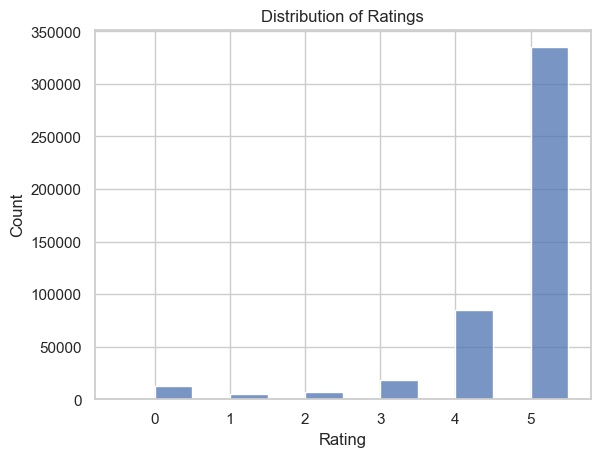

In [13]:
sns.histplot(data=data, x='rating', binwidth=0.5, binrange=(-0.5, 5.5), bins=6)
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.savefig("vizs/viz7.png")
plt.show()

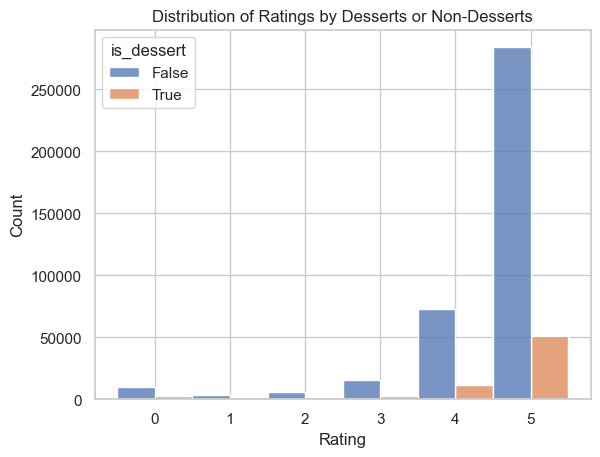

In [14]:
sns.histplot(data=data, hue='is_dessert', x='rating', multiple="dodge", binwidth=1, binrange=(-0.5, 5.5))
plt.title("Distribution of Ratings by Desserts or Non-Desserts")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.savefig("vizs/viz8.png")
plt.show()

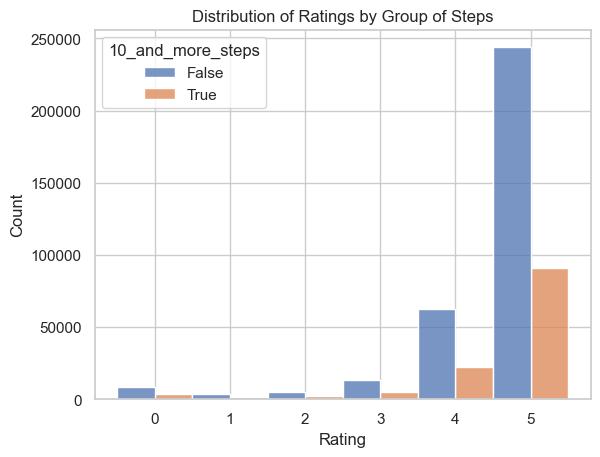

In [15]:
sns.histplot(data=data, hue='10_and_more_steps', x='rating', multiple="dodge", binwidth=1, binrange=(-0.5, 5.5))
plt.title("Distribution of Ratings by Group of Steps")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.savefig("vizs/viz9.png")
plt.show()

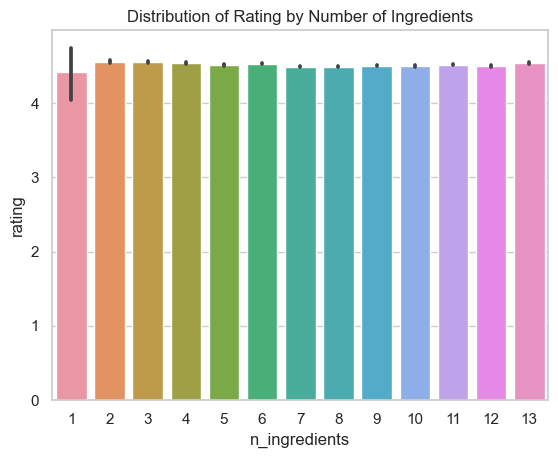

In [16]:
sns.barplot(data=data, x="n_ingredients", y="rating")
plt.title("Distribution of Rating by Number of Ingredients")
plt.savefig("vizs/viz10.png")
plt.show()

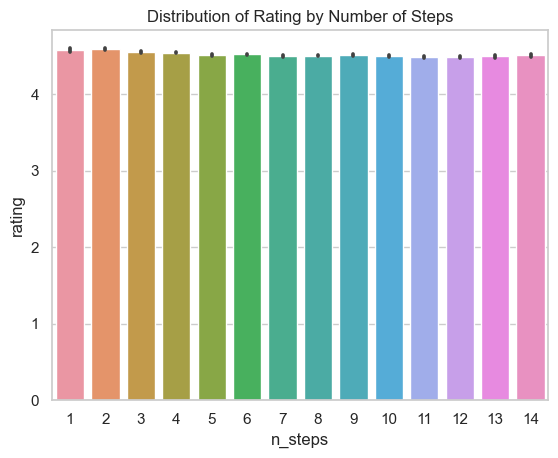

In [17]:
sns.barplot(data=data, x="n_steps", y="rating")
plt.title("Distribution of Rating by Number of Steps")
plt.savefig("vizs/viz11.png")
plt.show()

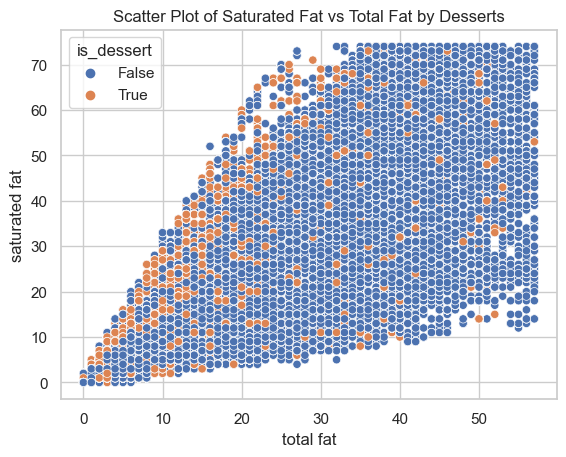

In [18]:
sns.scatterplot(data=data, x="total fat", y="saturated fat", hue="is_dessert")
plt.title("Scatter Plot of Saturated Fat vs Total Fat by Desserts")
plt.savefig("vizs/viz12.png")
plt.show()

In [19]:
np.random.seed(1)
is_adj = lambda pos: pos[:2] == 'JJ'

def extract_adj(txt):
    tokenized = nltk.word_tokenize(txt)
    adj = [word for (word, pos) in nltk.pos_tag(tokenized) if is_adj(pos)]
    return adj

In [20]:
def generate_word_cloud():
    word_cloud = []

    unique_ratings = sorted(data["rating"].unique())
    for rating in unique_ratings:
        temp_text = data[data["rating"]== rating]["review"]
        rand_idx = np.random.choice(range(0, len(temp_text)), 2500, replace=False)
        temp_text = temp_text.iloc[rand_idx]
        collapsed_temp_text = temp_text.str.cat(sep=' ')
        word_cloud += [extract_adj(collapsed_temp_text)]

    word_clouds = []
    for sub in word_cloud:
        counter = Counter(sub)
        most_occur = counter.most_common(100)
        word_clouds += [most_occur]

    word_clouds = [wc[3:-3] for wc in word_clouds]
    
    word_clouds = [{t[0]:t[1] for t in rate} for rate in word_clouds]

    for idx, rate in enumerate(word_clouds[1:]):
        wordcloud = WordCloud()
        wordcloud.generate_from_frequencies(frequencies=rate)
        plt.figure()
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.title("100 Most Common Words With Rating Of " + str(idx+1))
        plt.axis("off")
        plt.show()

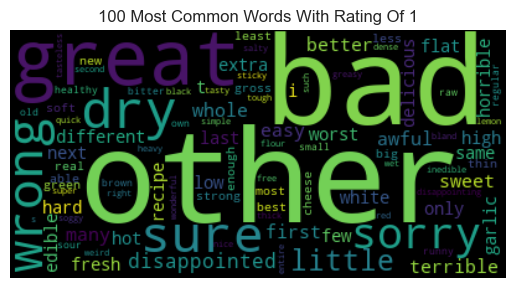

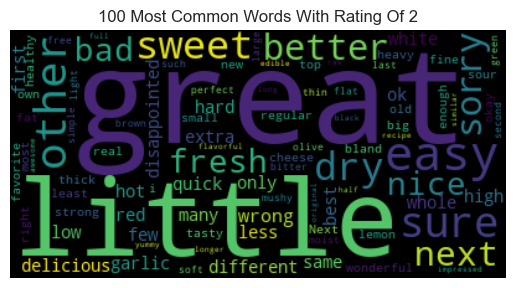

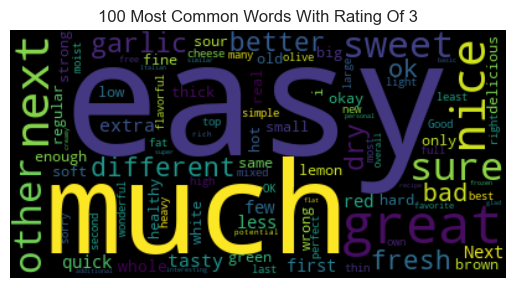

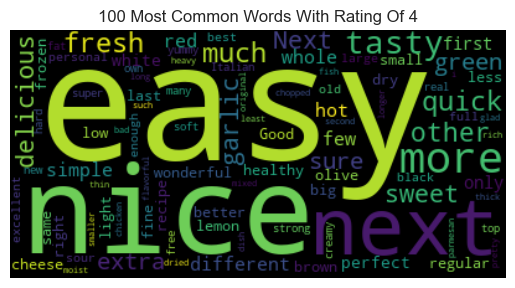

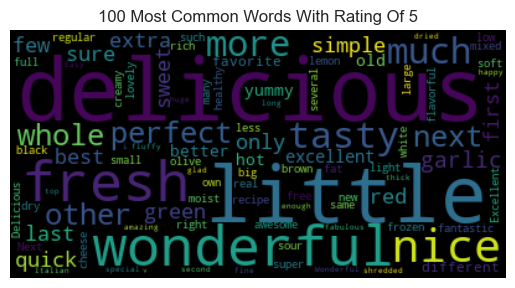

In [21]:
try:
    generate_word_cloud()
except:
    print("please rerun this cell")
    nltk.download('punkt')
    nltk.download('averaged_perceptron_tagger')

## Predictive Models

In [22]:
def mse(preds, actuals):
    return np.mean(
        (np.array(preds).reshape(1, -1) - np.array(actuals).reshape(1, -1))**2
    )

def accuracy(preds, actuals):
    return np.mean(
        np.array(preds).reshape(1, -1) == np.array(actuals).reshape(1, -1)
    )

## Recipe Recommendation

In [23]:
df = data[['user_id', 'recipe_id', 'rating']]
all_rate = df.to_numpy()
all_recipe = set(all_rate[...,1])
all_user = set(all_rate[...,0])

In [24]:
pos_sample = [[u,b,1] for u,b,_ in all_rate]
rate_per_recipe = defaultdict(list)
rate_per_user = defaultdict(list)
recipe_count_per_user = defaultdict(list)
for u,b,_ in all_rate:
    rate_per_user[u] += [b]
    rate_per_recipe[b] += [u]
for k,v in rate_per_user.items():
    recipe_count_per_user[k] = len(rate_per_user[k])

neg_sample = []
for u in tqdm(all_user):
    limit = recipe_count_per_user[u]
    recipe = all_recipe.difference(rate_per_recipe[b])
    neg = np.random.choice(list(recipe), size=limit)
    for b in neg:
        neg_sample += [[u,b,0]]
pos_neg = pos_sample + neg_sample

100%|██████████| 104671/104671 [07:58<00:00, 218.86it/s]


In [25]:
recipeCount = defaultdict(int)
totalRead = 0

for user,recipe,_ in all_rate:
    recipeCount[recipe] += 1
    totalRead += 1

In [26]:
r_train, r_test = train_test_split(pos_neg, train_size=0.75, random_state=58, shuffle=True)
train_pos_neg = np.hstack((np.array([recipeCount[s[1]] for s in r_train]).reshape(-1,1), np.array(r_train)[...,2].astype(int).reshape(-1,1)))
test_pos_neg = np.hstack((np.array([recipeCount[s[1]] for s in r_test]).reshape(-1,1), np.array(r_test)[...,2].astype(int).reshape(-1,1)))
X_r_train, X_r_test = train_pos_neg[...,0], test_pos_neg[...,0]
y_r_train, y_r_test = train_pos_neg[...,1], test_pos_neg[...,1]

In [27]:
clf = RandomForestClassifier(n_estimators=10, max_depth=20, random_state=0)
clf.fit(X_r_train.reshape(-1,1), y_r_train)

RandomForestClassifier(max_depth=20, n_estimators=10, random_state=0)

In [28]:
read_test = r_test
X_test = np.array([recipeCount[b] for b in np.array(read_test)[...,1]]).reshape(-1,1)
y_test = clf.predict_proba(X_test)[...,1]
read_test = pd.DataFrame(read_test).assign(prediction=y_test).groupby(0).apply(lambda x: x.sort_values('prediction'))
y_r_test = read_test[[2]].to_numpy()
read_test = read_test.drop(columns=2)

In [29]:
X_read_test = pd.DataFrame(read_test.to_numpy()).to_numpy()
X_read_rank = defaultdict(list)
for u,b,p in X_read_test:
    X_read_rank[u] += [[b,p]]

final_pred = []
for u in X_read_rank.keys():
    num = len(X_read_rank[u])//2
    for v in range(len(X_read_rank[u])):
        if v < num:
            final_pred += [[u,X_read_rank[u][v][0],0]]
        else:
            final_pred += [[u,X_read_rank[u][v][0],1]]
print(f"Testing Accuracy for this RFC model is {np.mean(np.array(final_pred)[...,-1] == y_r_test.flatten())}.")

Testing Accuracy for this RFC model is 0.6920211960635881.


## Rating Prediction (By Reviews)

In [30]:
lr_X_train, lr_X_test = train_test_split(data, train_size=0.75, random_state=58, shuffle=True)
train_word2vec = lr_X_train[['user_id', 'recipe_id', 'rating']].astype({"user_id": str, "recipe_id": str}).to_numpy()
train_reci = lr_X_train['recipe_id'].astype(str).to_numpy()
train_user = lr_X_train['user_id'].astype(str).to_numpy()
train_rating = lr_X_train['rating'].to_numpy()

test_word2vec = lr_X_test[['user_id', 'recipe_id', 'rating']].astype({"user_id": str, "recipe_id": str}).to_numpy()
test_reci = lr_X_test['recipe_id'].astype(str).to_numpy()
test_user = lr_X_test['user_id'].astype(str).to_numpy()
test_rating = lr_X_test['rating'].to_numpy()

In [31]:
reviewsPerUser = defaultdict(list)
for i in range(len(train_reci)):
    reviewsPerUser[train_user[i]].append(train_reci[i])
reviewList = [reviewsPerUser[each] for each in reviewsPerUser]
model = Word2Vec(reviewList, min_count=1, vector_size=10, window=3, sg=1)

itemAverages = defaultdict(list)
ratingMean = []
for i in range(len(train_reci)):
    itemAverages[train_reci[i]].append(train_rating[i])
    ratingMean.append(train_rating[i])

for b in itemAverages:
    itemAverages[b] = sum(itemAverages[b]) / len(itemAverages[b])

ratingMean = sum(ratingMean) / len(ratingMean)
reviewsPerUser_ = defaultdict(list)
for i in range(len(train_user)):
    reviewsPerUser_[train_user[i]].append(train_word2vec[i])

In [32]:
def Cosine(x1,x2):
    x1, x2 = np.array(x1), np.array(x2)
    numer = (x1*x2).sum()
    norm1 = (x1**2).sum()
    norm2 = (x2**2).sum()
    if norm1*norm2:
        return numer / np.sqrt(norm1*norm2)
    return 0

def predictRating(user,item):
    ratings = []
    similarities = []
    for d in reviewsPerUser_[user]:
        i2 = d[1]
        if i2 == item: continue
        ratings.append(d[2] - itemAverages[i2])
        if item not in model.wv or i2 not in model.wv:
            c = 0
        else:
            c = Cosine(model.wv[item], model.wv[i2])
        similarities.append(c)
    if (sum(similarities) > 0):
        weightedRatings = np.array(ratings) * np.array(similarities)
        return np.clip(itemAverages[item] + sum(weightedRatings) / sum(similarities), 0, 5)
    else:
        # User hasn't rated any similar items
        return ratingMean

In [33]:
simPredictions = [predictRating(train_user[i], train_reci[i]) for i in tqdm(range(len(train_user)))]
labels = [train_rating[i] for i in range(len(train_user))]
print(f"Training MSE for this weighted model is {mse(simPredictions, labels)}.")

100%|██████████| 346762/346762 [09:15<00:00, 624.11it/s]


Training MSE for this weighted model is 1.0667860065721304.


In [34]:
simPredictions_test = [predictRating(test_user[i], test_reci[i]) for i in tqdm(range(len(test_user)))]
labels_test = [test_rating[i] for i in tqdm(range(len(test_user)))]
print(f"Testing MSE for this weighted model is {mse(simPredictions_test, labels_test)}.")

100%|██████████| 115588/115588 [00:00<00:00, 6418705.04it/s]

Testing MSE for this weighted model is 1.168152305448988.


# Rating Prediction

In [35]:
df = data[['user_id', 'recipe_id', 'rating']]
X_train, X_test = train_test_split(df.to_numpy(), train_size=0.75, random_state=58, shuffle=True)
X_train, X_test = pd.DataFrame(X_train, columns=['user_id', 'recipe_id', 'rating']), pd.DataFrame(X_test, columns=['user_id', 'recipe_id', 'rating'])
improve_train_data = Dataset.load_from_df(X_train, reader=Reader(rating_scale=(1,5)))
train_data = improve_train_data.build_full_trainset()


improve_param = {
    'random_state': 58,
    'n_epochs': 55,
    'lr_all': 0.004,
    'lr_bu': 0.004,
    'lr_bi': 0.002,
    'lr_yj': 0.008,
    'reg_all': 0.3,
    'reg_bu': 0.235,
    'reg_bi': 0.3,
    'reg_yj': 0.2,
    'n_factors': 3
    }

improve_model = SVDpp(
    random_state=improve_param['random_state'], 
    n_epochs=improve_param['n_epochs'], 
    lr_all=improve_param['lr_all'], 
    lr_bu=improve_param['lr_bu'], 
    lr_bi=improve_param['lr_bi'], 
    lr_yj=improve_param['lr_yj'],
    reg_all=improve_param['reg_all'], 
    reg_bu=improve_param['reg_bu'], 
    reg_bi=improve_param['reg_bi'], 
    reg_yj=improve_param['reg_yj'],
    n_factors=improve_param['n_factors']
    )

improve_model.fit(train_data)

improve_train_preds = np.array(X_train[['user_id', 'recipe_id']].apply(lambda x: improve_model.predict(x[0], x[1]).est, axis=1))
train_actuals = np.array(X_train['rating'])
print(f"Training MSE for this baseline model is {mse(improve_train_preds, train_actuals)}.")


improve_test_preds = np.array(X_test[['user_id', 'recipe_id']].apply(lambda x: improve_model.predict(x[0], x[1]).est, axis=1))
test_actuals = np.array(X_test['rating'])
print(f"Testing MSE for this baseline model is {mse(improve_test_preds, test_actuals)}.")

Training MSE for this baseline model is 0.6183473389219369.
Testing MSE for this baseline model is 0.9798192498779724.


In [36]:
lr = LinearRegression()
lr.fit(lr_X_train['sentiment'].to_numpy().reshape(-1,1), lr_X_train['rating'].to_numpy().reshape(-1,1))
lr_train_preds = lr.predict(lr_X_train['sentiment'].to_numpy().reshape(-1,1)).flatten()
lr_test_preds = lr.predict(lr_X_test['sentiment'].to_numpy().reshape(-1,1)).flatten()
        
final_train_preds = (improve_train_preds + lr_train_preds)/2
print(f"Training MSE for this weighted model is {mse(X_train['rating'], final_train_preds)}.")

final_test_preds = (improve_test_preds + lr_test_preds)/2
print(f"Testing MSE for this weighted model is {mse(X_test['rating'], final_test_preds)}.")

Training MSE for this weighted model is 0.7762499641909667.
Testing MSE for this weighted model is 0.9649562528798364.


# Desserts Prediction

In [37]:
X_train, X_test, y_train, y_test = train_test_split(data[['total fat', 'saturated fat', 'sugar']], data[['is_dessert']], train_size=0.75, random_state=58, shuffle=True)

def tune_weights():
    accs = []
    for i in range(0, 101):
        train_preds = np.array(X_train['sugar'])>i
        accs.append(accuracy(train_preds, y_train))
    return np.argmax(accs)
best_threshold = tune_weights()
baseline_train_preds = np.array(X_train['sugar'])>best_threshold
baseline_test_preds = np.array(X_test['sugar'])>best_threshold 


print(f"Training Accuracy for this baseline model is {accuracy(baseline_train_preds, y_train)}.")
print(f"Testing Accuracy for this baseline model is {accuracy(baseline_test_preds, y_test)}.")

Training Accuracy for this baseline model is 0.8454963346618142.
Testing Accuracy for this baseline model is 0.8456587188981555.


In [38]:
clf = RandomForestClassifier(
    max_depth=17, 
    random_state=17, 
    criterion='entropy', 
    n_estimators=17, 
    max_features='log2')
clf.fit(X_train, y_train)
improve_train_preds = clf.predict(X_train)
improve_test_preds = clf.predict(X_test)
print(f"Training Accuracy for this improved model is {accuracy(improve_train_preds, y_train)}.")
print(f"Testing Accuracy for this improved model is {accuracy(improve_test_preds, y_test)}.")

Training Accuracy for this improved model is 0.9523650226956818.
Testing Accuracy for this improved model is 0.9438350001730283.
